# Libraries and dependencies

In [1]:
import geopandas as gpd
import geoplot as gplt
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point

%matplotlib inline

# Catch fish data for one year

In [2]:
# Load csv.zip file
file_path = 'Catch Notes Datasets\\fangstdata_2005.csv.zip'
data_catch_raw = pd.read_csv(file_path, compression='zip', encoding='ISO-8859-1', delimiter=';', low_memory=False)

print(data_catch_raw.head())

   ï»¿Dokumentnummer  Dokumenttype (kode)         Dokumenttype  \
0       200000833835                    0  Sluttseddeldokument   
1       200000833835                    0  Sluttseddeldokument   
2       200000833835                    0  Sluttseddeldokument   
3       200000833835                    0  Sluttseddeldokument   
4       200000833836                    0  Sluttseddeldokument   

   Dokument versjonsnummer Dokument salgsdato Dokument versjonstidspunkt  \
0                        1         23.05.2005                 30.05.2005   
1                        1         23.05.2005                 30.05.2005   
2                        1         23.05.2005                 30.05.2005   
3                        1         23.05.2005                 30.05.2005   
4                        1         23.05.2005                 30.05.2005   

   Salgslag ID  Salgslag (kode)          Salgslag  Mottaker ID  ...  \
0    946768871                2  Skagerakfisk S/L  953264560.0  ...   
1   

In [3]:
# Keep the following columns: Landingsdato, Lon (hovedområde), Lat (hovedområde), Produktvekt
keep_columns = ['Landingsdato', 'Lon (hovedomrÃ¥de)', 'Lat (hovedomrÃ¥de)', 'Produktvekt']
data_catch = data_catch_raw.loc[:, keep_columns]

# Rename the columns
new_column_names = ['Date', 'Longitude', 'Latitude', 'Weight']
data_catch = data_catch.rename(columns=dict(zip(data_catch.columns, new_column_names)))

# Convert Longitude and Latitude columns to numeric, and Date to datetime
data_catch['Longitude'] = data_catch['Longitude'].str.replace(',', '.').astype(float)
data_catch['Latitude'] = data_catch['Latitude'].str.replace(',', '.').astype(float)
data_catch['Date'] = pd.to_datetime(data_catch['Date'])

print(data_catch.head())

        Date  Longitude  Latitude Weight
0 2005-05-23   10.42851   57.8435    4,5
1 2005-05-23   10.42851   57.8435    5,5
2 2005-05-23   10.42851   57.8435    6,4
3 2005-05-23   10.42851   57.8435      4
4 2005-05-23   10.42851   57.8435    1,5


C:\Users\dccar\AppData\Local\Temp\ipykernel_27632\2875079980.py:12: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_catch['Date'] = pd.to_datetime(data_catch['Date'])


In [4]:
# Create a new column for geometry
data_catch['geometry'] = data_catch.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(data_catch, geometry='geometry')

C:\Users\dccar\AppData\Local\Temp\ipykernel_27632\501626301.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


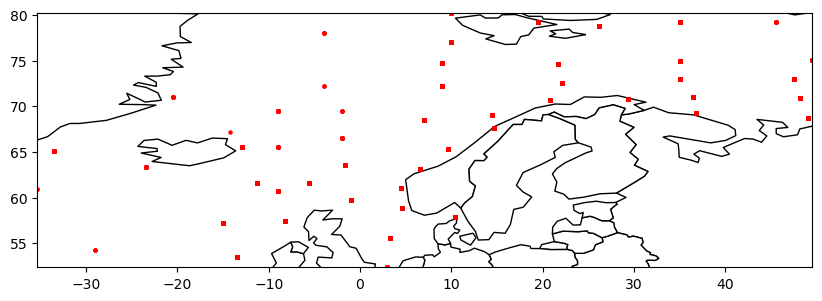

In [5]:
# Get the maximum and minimum latitude and longitude - We will use these to set the boundaries of the maps
max_latitude = data_catch['Latitude'].max()
min_latitude = data_catch['Latitude'].min()
max_longitude = data_catch['Longitude'].max()
min_longitude = data_catch['Longitude'].min()

# Create a map within the boundaries
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(min_longitude, max_longitude)
ax.set_ylim(min_latitude, max_latitude)

# Plot the GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

plt.show()

# Salinity data for one month

Let us analize the salinity dataset for January 2021

In [6]:
# Load the NetCDF file - Note that other libraries can be used to load NetCDF files
file_path = 'Salinity Data - Monthly Average\salinity_data\RSS_smap_SSS_L3_monthly_2021_01_FNL_v04.0.nc'
data_salinity = xr.open_dataset(file_path)

print(data_salinity.variables.keys())

KeysView(Frozen({'lon': <xarray.IndexVariable 'lon' (lon: 1440)>
array([1.25000e-01, 3.75000e-01, 6.25000e-01, ..., 3.59375e+02, 3.59625e+02,
       3.59875e+02], dtype=float32)
Attributes:
    standard_name:  longitude
    axis:           X
    long_name:      center longitude of grid cell
    units:          degrees_east
    valid_min:      0.0
    valid_max:      360.0, 'lat': <xarray.IndexVariable 'lat' (lat: 720)>
array([-89.875, -89.625, -89.375, ...,  89.375,  89.625,  89.875],
      dtype=float32)
Attributes:
    standard_name:  latitude
    axis:           Y
    long_name:      center latitude of grid cell
    units:          degrees_north
    valid_min:      -90.0
    valid_max:      90.0, 'time': <xarray.IndexVariable 'time' (time: 1)>
array(['2021-01-16T11:59:59.500000000'], dtype='datetime64[ns]')
Attributes:
    standard_name:  time
    axis:           T
    long_name:      reference time of analyzed variable field corresponding t..., 'nobs': <xarray.Variable (lat: 720, l

In [7]:
# Extract salinity, uncertainty, and relevant coordinates
sal = data_salinity['sss_smap']
sal_uncertainty = data_salinity['sss_smap_uncertainty']
sal_lon = data_salinity['lon']
sal_lat = data_salinity['lat']

In [8]:
# Create a meshgrid from the lon and lat arrays
lon, lat = np.meshgrid(sal_lon, sal_lat)

# Flatten the meshgrid and the sal and sal_uncertainty arrays
lon_flat = lon.flatten()
lat_flat = lat.flatten()
sal_flat = sal.values.flatten()
sal_uncertainty_flat = sal_uncertainty.values.flatten()

# Create a DataFrame
sal_df = pd.DataFrame({
    'lon': lon_flat,
    'lat': lat_flat,
    'sal': sal_flat,
    'sal_uncertainty': sal_uncertainty_flat
})

sal_df.head()

,lon,lat,sal,sal_uncertainty
0,0.125,-89.875,NaN,NaN
1,0.375,-89.875,NaN,NaN
2,0.625,-89.875,NaN,NaN
3,0.875,-89.875,NaN,NaN
4,1.125,-89.875,NaN,NaN


In [9]:
# Create a geometry column in the DataFrame
sal_df['geometry'] = [Point(xy) for xy in zip(sal_df['lon'], sal_df['lat'])]

# Convert the DataFrame to a GeoDataFrame
sal_gdf = gpd.GeoDataFrame(sal_df, geometry='geometry')

sal_gdf.head()

,lon,lat,sal,sal_uncertainty,geometry
0,0.125,-89.875,NaN,NaN,POINT (0.12500 -89.87500)
1,0.375,-89.875,NaN,NaN,POINT (0.37500 -89.87500)
2,0.625,-89.875,NaN,NaN,POINT (0.62500 -89.87500)
3,0.875,-89.875,NaN,NaN,POINT (0.87500 -89.87500)
4,1.125,-89.875,NaN,NaN,POINT (1.12500 -89.87500)


In [10]:
# Define a function to convert longitude values
def convert_longitude(lon):
    return lon if lon <= 180 else lon - 360

# Apply the function to the lon column
sal_gdf['lon'] = sal_gdf['lon'].apply(convert_longitude)

# Update the geometry column with the new longitude values
sal_gdf['geometry'] = [Point(xy) for xy in zip(sal_gdf['lon'], sal_gdf['lat'])]


C:\Users\dccar\AppData\Local\Temp\ipykernel_27632\1643557362.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


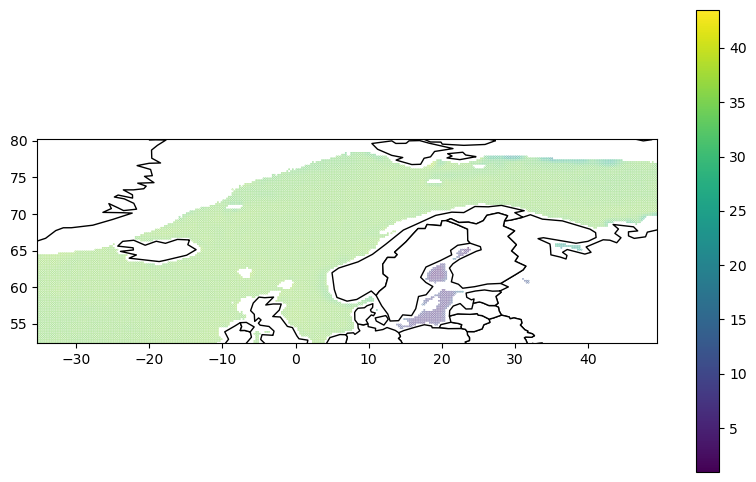

In [11]:
# Create a map within the boundaries
fig, ax = plt.subplots(figsize=(10, 6))

# Set the x and y limits of the plot
ax.set_xlim(min_longitude, max_longitude)
ax.set_ylim(min_latitude, max_latitude)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='white', edgecolor='black')

# Plot the GeoDataFrame on the same axes
sal_gdf.plot(ax=ax, column='sal', cmap='viridis', legend=True, markersize=0.05)

plt.show()

# Temperature data for one year

In [2]:
# Load the NetCDF file
file_path = 'Temperature\sst.day.mean.2021.nc'
data_temperature = xr.open_dataset(file_path)

print(data_temperature.variables.keys())

KeysView(Frozen({'time': <xarray.IndexVariable 'time' (time: 365)>
array(['2021-01-01T00:00:00.000000000', '2021-01-02T00:00:00.000000000',
       '2021-01-03T00:00:00.000000000', ..., '2021-12-29T00:00:00.000000000',
       '2021-12-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:     Time
    delta_t:       0000-00-01 00:00:00
    avg_period:    0000-00-01 00:00:00
    axis:          T
    actual_range:  [80719. 81083.], 'lat': <xarray.IndexVariable 'lat' (lat: 720)>
array([-89.875, -89.625, -89.375, ...,  89.375,  89.625,  89.875],
      dtype=float32)
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    actual_range:   [-89.875  89.875]
    axis:           Y, 'lon': <xarray.IndexVariable 'lon' (lon: 1440)>
array([1.25000e-01, 3.75000e-01, 6.25000e-01, ..., 3.59375e+02, 3.59625e+02,
       3.59875e+02], dtype=float32)
Attributes:
    long_name:      Longitude
    

In [3]:
# Extract temperature and relevant coordinates
latitude = data_temperature['lat'].values
longitude = data_temperature['lon'].values
dates = pd.to_datetime(data_temperature['time'].values)
temperature = data_temperature['sst'].values

In [4]:
# Create a DataFrame
temp_df = pd.DataFrame({
    'date': dates.repeat(len(latitude) * len(longitude)),
    'longitude': list(longitude) * len(dates) * len(latitude),
    'latitude': list(latitude) * len(dates) * len(longitude),
    'temperature': temperature.flatten()
})

temp_df.head()

,date,longitude,latitude,temperature
0,2021-01-01,0.125,-89.875,NaN
1,2021-01-01,0.375,-89.625,NaN
2,2021-01-01,0.625,-89.375,NaN
3,2021-01-01,0.875,-89.125,NaN
4,2021-01-01,1.125,-88.875,NaN


In [5]:
# Create a DataFrame with unique pairs of longitude and latitude
unique_coords_df = temp_df[['longitude', 'latitude']].drop_duplicates()

# Create a geometry column in the DataFrame
unique_coords_df['geometry'] = [Point(xy) for xy in zip(unique_coords_df['longitude'], unique_coords_df['latitude'])]

# Merge the DataFrame with the original DataFrame
temp_df = pd.merge(temp_df, unique_coords_df, on=['longitude', 'latitude'])

# Convert the DataFrame to a GeoDataFrame
temp_gdf = gpd.GeoDataFrame(temp_df, geometry='geometry')

temp_gdf.head()

In [ ]:
# Define a function to convert longitude values
def convert_longitude(lon):
    return lon if lon <= 180 else lon - 360

# Apply the function to the lon column
temp_gdf['lon'] = sal_gdf['lon'].apply(convert_longitude)

# Update the geometry column with the new longitude values
temp_gdf['geometry'] = [Point(xy) for xy in zip(temp_gdf['lon'], temp_gdf['lat'])]

In [ ]:
# Create a map within the boundaries
fig, ax = plt.subplots(figsize=(10, 6))

# Set the x and y limits of the plot
ax.set_xlim(min_longitude, max_longitude)
ax.set_ylim(min_latitude, max_latitude)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='white', edgecolor='black')

# Plot the GeoDataFrame on the same axes
temp_gdf.plot(ax=ax, column='temperature', cmap='viridis', legend=True, markersize=0.05)

plt.show()

# Align catch notes with salinity and temperature dataset

Note that the latitude-longitude in the catch notes dataset is not align with respect to the other datasets